In [1]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from datetime import datetime

def fix_vector(x):
    if type(x) == dict:
        return np.array(list(x.values()), dtype=float)

files = ['P1/U3/2019-08-23-10-08-46_Session_2_Scene_Voicedraw_User_3_Name_Dafat_Player_1_PH_Right.json',
         'P2/U4/2019-08-23-10-08-47_Session_2_Scene_Voicedraw_User_4_Name_Brnor_Player_2_PH_Left.json']   
    
sdf = pd.DataFrame() #creates a new dataframe that's empty

for file in files:
    with open(file, 'r') as f:
         data = json.load(f)


    df = json_normalize(data,record_path=['Events'])

    # Fix position data, convert from dict to numpy array
    df.endPosition.fillna(value=np.nan, inplace=True)
    df.startPosition = df.startPosition.apply(lambda x: fix_vector(x))        
    df.endPosition = df.endPosition.apply(lambda x: fix_vector(x))

    # Fix Time
    
    df.dateTime = df.dateTime.apply(lambda x: x.replace("T","-"))
    df.dateTime = df.dateTime.apply(lambda x: x.replace(":"," "))
    df.dateTime = df.dateTime.apply(lambda x: x.replace("."," "))
    df.dateTime = df.dateTime.apply(lambda x: x.replace("-"," "))
    # Remove the last millisecond unit
    df.dateTime = df.dateTime.apply(lambda x: x[0:-1])
    df.dateTime = df.dateTime.apply(lambda x: np.datetime64(datetime.strptime(x, '%Y %m %d %H %M %S %f')))

    # Remove redundant cols
    valuelist = ['avgVelocity','duration','finalValue','hand','id','initialValue','owner']
    df = df.drop(columns=valuelist)

    # Parse Teleports
    valuelist = ['PlayerConnect','Teleport']
    df = df[df.logType.isin(valuelist)]
    df = df.reset_index()
    df = df.drop(columns='level_0')
    df['uid'] = file[4]
    
    df.at[1,'startPosition'] = np.array([0.0,0.0,0.0],dtype=float)
    for i in range( 2,len(df.index) ):
        df.at[i,'startPosition'] = df.endPosition.iloc[i-1]
        
    sdf = sdf.append(df, ignore_index = True) # ignoring index is optional

sdf = sdf.sort_values('dateTime')
sdf = sdf.reset_index()
sdf = sdf.drop(columns='level_0')
# inter-personal teleport distance
sdf['iptd'] = 0.0

# lookup
lup = {}
lup['3'] = np.array([0.0,0.0,0.0],dtype=float)
lup['4'] = np.array([0.0,0.0,0.0],dtype=float)

for i in range( 2,len(sdf.index) ):
    #print(i)
    # Update last position of player who TELEPORTED
    uid = sdf.at[i,'uid']
    #print(uid)
    lup[uid] = sdf.at[i,'endPosition']
    #print(lup[uid])
    # Compute distance from current end position to last position of other player
    sdf.at[i,'iptd'] = np.linalg.norm(lup['3']-lup['4'])

sdf['dt'] = 0
# int(round(sdf.at[0,'dateTime'].timestamp() * 1e3))
for i in range(1,len(sdf.index)):
    sdf.at[i,'dt'] = sdf.at[i,'dateTime'].timestamp() - sdf.at[0,'dateTime'].timestamp()

In [2]:
from beakerx import *
import time

plot = TimePlot()

plot.add(Line(x=sdf.dt, y=sdf.iptd))
plot.add(ConstantLine(x=sdf.dt[1:1], style=StrokeType.DOT, color=Color.red))
plot

In [3]:
from datetime import datetime
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from beakerx import *
import time

def fix_vector(x):
    if type(x) == dict:
        return np.array(list(x.values()), dtype=float)

def parse_teleport_df(user_id):
    p1 = str(user_id)
    p2 = str(user_id+1)
    print("Getting data for " + p1 + " and " + p2)
    tf = ['U/X.json','U/X.json']
    tf[0] = tf[0].replace("X",p1)
    tf[1] = tf[1].replace("X",p2)
    sdf = pd.DataFrame() #creates a new dataframe that's empty
    print("From " + tf[0] + " and " + tf[1])
    for file in tf:
        with open(file, 'r') as f:
             data = json.load(f)

        df = json_normalize(data,record_path=['Events'])

        # Fix position data, convert from dict to numpy array
        df.endPosition.fillna(value=np.nan, inplace=True)
        df.startPosition = df.startPosition.apply(lambda x: fix_vector(x))        
        df.endPosition = df.endPosition.apply(lambda x: fix_vector(x))

        # Fix Time
        
        df.dateTime = df.dateTime.apply(lambda x: x.replace("T","-"))
        df.dateTime = df.dateTime.apply(lambda x: x.replace(":"," "))
        df.dateTime = df.dateTime.apply(lambda x: x.replace("."," "))
        df.dateTime = df.dateTime.apply(lambda x: x.replace("-"," "))
        # Remove the last millisecond unit
        df.dateTime = df.dateTime.apply(lambda x: x[0:-1])
        df.dateTime = df.dateTime.apply(lambda x: np.datetime64(datetime.strptime(x, '%Y %m %d %H %M %S %f')))

        # Remove redundant cols
        valuelist = ['avgVelocity','duration','finalValue','hand','id','initialValue','owner']
        df = df.drop(columns=valuelist)

        # Parse Teleports
        valuelist = ['PlayerConnect','Teleport']
        df = df[df.logType.isin(valuelist)]
        df = df.reset_index()
        df = df.drop(columns='level_0')

        if int(float(file[2:4])) < 10:
            df['uid'] = file[2]
        else:
            df['uid'] = file[2:4]

        df.at[1,'startPosition'] = np.array([0.0,0.0,0.0],dtype=float)
        for i in range( 2,len(df.index) ):
            df.at[i,'startPosition'] = df.endPosition.iloc[i-1]

        sdf = sdf.append(df, ignore_index = True) # ignoring index is optional

    sdf = sdf.sort_values('dateTime')
    sdf = sdf.reset_index()
    sdf = sdf.drop(columns='level_0')
    # inter-personal teleport distance
    sdf['iptd'] = 0.0

    # lookup
    lup = {}
    lup[str(user_id)] = np.array([0.0,0.0,0.0],dtype=float)
    lup[str(user_id+1)] = np.array([0.0,0.0,0.0],dtype=float)

    for i in range( 2,len(sdf.index) ):
        #print(i)
        # Update last position of player who TELEPORTED
        uid = sdf.at[i,'uid']
        #print(uid)
        lup[uid] = sdf.at[i,'endPosition']
        #print(lup[uid])
        # Compute distance from current end position to last position of other player
        sdf.at[i,'iptd'] = np.linalg.norm(lup[str(user_id)]-lup[str(user_id+1)])

    sdf['dt'] = 0
    # int(round(sdf.at[0,'dateTime'].timestamp() * 1e3))
    for i in range(1,len(sdf.index)):
        sdf.at[i,'dt'] = sdf.at[i,'dateTime'].timestamp() - sdf.at[0,'dateTime'].timestamp()
    
    return sdf


In [4]:

sdfs = []
for i in range(1,12,2):
    sdfs.append(parse_teleport_df(i))
    

Getting data for 1 and 2
From U/1.json and U/2.json
Getting data for 3 and 4
From U/3.json and U/4.json
Getting data for 5 and 6
From U/5.json and U/6.json
Getting data for 7 and 8
From U/7.json and U/8.json
Getting data for 9 and 10
From U/9.json and U/10.json
Getting data for 11 and 12
From U/11.json and U/12.json


In [5]:
from datetime import timedelta

plot = TimePlot(legendLayout= LegendLayout.HORIZONTAL, legendPosition= LegendPosition(position=LegendPosition.Position.TOP))
cc = [Color.magenta, Color.red, Color.orange, Color.green, Color.blue, Color.pink]

now = datetime.fromtimestamp(0)

for s in sdfs:
    sid = int((int(s.uid[0])+1)/2)
    # Could apply offset here to get rough sync points on videos? Not for overall dispaly though. 
    t = s.dt.apply(lambda x: now+timedelta(seconds=x))
    
    plot.add(Points      (x= t, y=s.iptd, size=10, shape=ShapeType.DIAMOND, displayName=str(sid)+"D", color=cc[sid-1]))
    plot.add(Line        (x= t, y=s.iptd, displayName=str(sid)+"L", color=cc[sid-1]))
    
    m = s.iptd.mean()
    std = s.iptd.std()
    
    plot.add(ConstantLine(y= m, displayName=str(sid)+"M", color=cc[sid-1], showLabel=True))
    plot.add(ConstantBand(y= [m-std/2, m+std/2], color=Color(cc[sid-1].R, cc[sid-1].G, cc[sid-1].B, 25), displayName=str(sid)+"B", ))
plot

In [6]:
plot = TimePlot(legendLayout= LegendLayout.HORIZONTAL, legendPosition= LegendPosition(position=LegendPosition.Position.TOP))
cc = [Color.magenta, Color.red, Color.orange, Color.green, Color.blue, Color.pink]
offsets = [0,0,0,0,0,39-15]

now = datetime.fromtimestamp(0)
sid = 6-1

# Could apply offset here to get rough sync points on videos? Not for overall dispaly though. 
t = sdfs[sid].dt.apply(lambda x: now+timedelta(seconds=x + offsets[sid]))

plot.add(Points      (x= t, y=sdfs[sid].iptd, size=10, shape=ShapeType.DIAMOND, displayName=str(sid)+"D", color=cc[sid-1]))
plot.add(Line        (x= t, y=sdfs[sid].iptd, displayName=str(sid)+"L", color=cc[sid-1]))

m = sdfs[sid].iptd.mean()
std = sdfs[sid].iptd.std()

plot.add(ConstantLine(y= m, displayName=str(sid)+"M", color=cc[sid-1], showLabel=True))
plot.add(ConstantBand(y= [m-std/2, m+std/2], color=Color(cc[sid-1].R, cc[sid-1].G, cc[sid-1].B, 25), displayName=str(sid)+"B", ))
plot

In [17]:
std

5.518272562279954

In [7]:
positions = sdfs[1][sdfs[1].logType=='Teleport']
# positions.endPosition.iloc[1][0,2]

positions['x'] = float(0)
positions['z'] = float(0)
for index, row in positions.iterrows():
    positions.loc[index,'x'] = positions.loc[index,'endPosition'][0,0]
    positions.loc[index,'z'] = positions.loc[index,'endPosition'][0,2]
#     positions.loc[index,'x'] = row.endPosition[0,0]
#     positions.loc[index,'z'] = row.endPosition[0,2]


C:\ProgramData\Anaconda3\envs\beakerx\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\beakerx\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\envs\beakerx\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [8]:
# Heatmap ref - 

pp = Plot(title='Bars, Lines, Points and 2nd yAxis', 
          xLabel="xLabel", 
          yLabel="yLabel", 
          legendLayout=LegendLayout.HORIZONTAL,
          legendPosition=LegendPosition(position=LegendPosition.Position.RIGHT))
pp.add(Points(x=positions[positions.uid=='3'].x, 
              y=positions[positions.uid=='3'].z, 
              size=10, 
              shape=ShapeType.DIAMOND))
pp.add(Points(x=positions[positions.uid=='4'].x, 
              y=positions[positions.uid=='4'].z, 
              size=10, 
              shape=ShapeType.DIAMOND))

pp



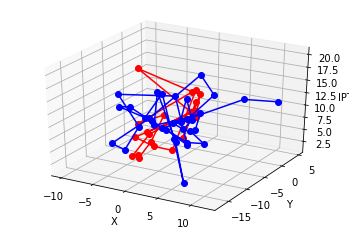

In [9]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =positions[positions.uid=='3'].x
y =positions[positions.uid=='3'].z
z =positions[positions.uid=='3'].iptd



ax.plot(x, y, z, c='r', marker='o')

x =positions[positions.uid=='4'].x
y =positions[positions.uid=='4'].z
z =positions[positions.uid=='4'].iptd

ax.plot(x, y, z, c='b', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('IPTD')
# ax.view_init(elev=15)
# ax.view_init(azim=45)

plt.show()